# Cài thư viện

In [8]:
import os
import torch
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
%matplotlib inline

# Sửa lỗi PosixPath

In [1]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# Tải và phát hiện đối tượng bằng YOLOV5

In [2]:
# Hàm tải mô hình YOLOv5
def load_yolov5_model(model_path):
    model = torch.hub.load('../yolov5', 'custom', 
                       path='../data/content/yolov5/runs/train/yolov5x_results/weights/best.pt', 
                       source='local', force_reload=True)
    return model

# Hàm phát hiện đối tượng từ ảnh
def detect_objects(model, image_path):
    results = model(image_path)
    detections = results.pandas().xyxy[0]  
    return detections

# Cắt các bounding box chuẩn bị ảnh cho CNN

In [3]:
# Hàm để cắt các bounding boxes từ ảnh
def crop_boxes(image_path, detections):
    image = cv2.imread(image_path)
    cropped_images = []
    for _, row in detections.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cropped_image = image[ymin:ymax, xmin:xmax]
        cropped_images.append(cropped_image)
    return cropped_images

# Hàm chuẩn bị ảnh cho CNN
def preprocess_for_cnn(cropped_images):
    processed_images = []
    for img in cropped_images:
        img_resized = cv2.resize(img, (150, 150))
        img_normalized = img_resized / 255.0
        processed_images.append(img_normalized)
    return np.array(processed_images)

# Tải mô hình CNN và phân loại

In [4]:
# Hàm tải mô hình CNN đã huấn luyện
def load_cnn_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

# Hàm phân loại ảnh với CNN
def classify_with_cnn(model, processed_images):
    predictions = model.predict(processed_images)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Thử nghiệm trên tập test

In [6]:
# Hàm thử nghiệm mô hình
def process_images_in_directory(image_directory, yolo_model, cnn_model):
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        detections = detect_objects(yolo_model, image_path)
        if detections.empty: 
            print(f"No objects detected in {image_file}. Skipping...") 
            continue
        cropped_images = crop_boxes(image_path, detections)
        processed_images = preprocess_for_cnn(cropped_images)
        predicted_labels = classify_with_cnn(cnn_model, processed_images)
        print(f"Predicted labels for {image_file}: {predicted_labels}")


yolo_model_path = '../data/content/yolov5/runs/train/yolov5x_results/weights/best.pt'  
cnn_model_path = '../Pycode/final_model.h5'  
image_directory = '../data/Lung_CT_Scan/valid/images'  

yolo_model = load_yolov5_model(yolo_model_path)
cnn_model = load_cnn_model(cnn_model_path)
process_images_in_directory(image_directory, yolo_model, cnn_model)
#10m 36s

YOLOv5  2024-11-7 Python-3.10.11 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 322 layers, 86193601 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicted labels for -101-2018061732-2172-itS2-380988-1_00014_jpg.rf.09c724a38e40c536a50bce6f3b4dddfc.jpg: [2 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted labels for -101-2018061732-4950-itS2-380958-1_00010_jpg.rf.8d3f3e9b4e695da5f36263b90626d61d.jpg: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted labels for -101-2018077075-1042-itS2-467243-1_00012_jpg.rf.a84dc5fb5805501f38f4d7de551b7421.jpg: [2 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted labels for -101-2018077075-1042-itS2-467243-1_00016_jpg.rf.359c87607afd2bca6271d4cf7b6bbdea.jpg: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted labels for -101-2018077075-5027-itS2-467192-1_00004_jpg.rf.26e5b7298ae4f7f67778f52c7b6266c3.jpg: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted labels for -101-2018077075-5027-itS2-467192-1_00006_jpg.rf.2b1f7ed617d1bbbff0fee0c95a96eb4b.jpg: [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted labels for -101-2018077075-5027-itS2-467192-1_00008_j

# Hàm đánh giá mô hình

In [18]:
# Hàm đọc nhãn từ file txt
def read_labels_from_txt(txt_file):
    labels = []
    with open(txt_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts:  
                labels.append(int(parts[0]))  
    return labels

# Hàm đánh giá mô hình
def evaluate_combined_model(image_directory, labels_directory, yolo_model, cnn_model, plot_graphs=True):
    true_labels = []      
    predicted_labels = [] 
    missed_images = 0    
    labels_dict = {
        os.path.splitext(f)[0]: read_labels_from_txt(os.path.join(labels_directory, f))
        for f in os.listdir(labels_directory) if f.endswith('.txt')
    }
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    start_time = time.time()
    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        label_file_key = os.path.splitext(image_file)[0]
        actual_labels = labels_dict.get(label_file_key, [])
        if not actual_labels:  
            print(f"No label or empty label file for {image_file}. Skipping...")
            continue

        detections = detect_objects(yolo_model, image_path)
        if detections.empty:  
            print(f"No objects detected in {image_file}. Adding missed detections...")
            missed_images += 1
            true_labels.extend(actual_labels)  
            predicted_labels.extend([-1] * len(actual_labels))  
            continue
        
        cropped_images = crop_boxes(image_path, detections)
        processed_images = preprocess_for_cnn(cropped_images)
        predicted = classify_with_cnn(cnn_model, processed_images)

        if len(predicted) < len(actual_labels):
            predicted = np.concatenate((predicted, [-1] * (len(actual_labels) - len(predicted))))
        elif len(predicted) > len(actual_labels):
            predicted = predicted[:len(actual_labels)]  
        true_labels.extend(actual_labels)
        predicted_labels.extend(predicted)
        
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total evaluation time: {total_time:.2f} seconds")

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    valid_indices = predicted_labels != -1  
    true_labels_filtered = true_labels[valid_indices]
    predicted_labels_filtered = predicted_labels[valid_indices]

    if len(true_labels_filtered) > 0 and len(predicted_labels_filtered) > 0:
        # In báo cáo phân loại
        report = classification_report(true_labels_filtered, predicted_labels_filtered, zero_division=0)
        print(report)

        # Tính toán và in Accuracy
        accuracy = accuracy_score(true_labels_filtered, predicted_labels_filtered)
        print(f"Accuracy: {accuracy:.2f}")

        # Vẽ ma trận nhầm lẫn 
        if plot_graphs:
            plt.figure(figsize=(8, 6))
            conf_matrix = confusion_matrix(true_labels_filtered, predicted_labels_filtered)
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=np.unique(true_labels_filtered), 
                        yticklabels=np.unique(true_labels_filtered))
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.show()

            # Vẽ đường cong ROC và tính AUC
            fpr, tpr, _ = roc_curve(true_labels_filtered, predicted_labels_filtered, pos_label=1)
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show() 

# Main

YOLOv5  2024-11-7 Python-3.10.11 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 322 layers, 86193601 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

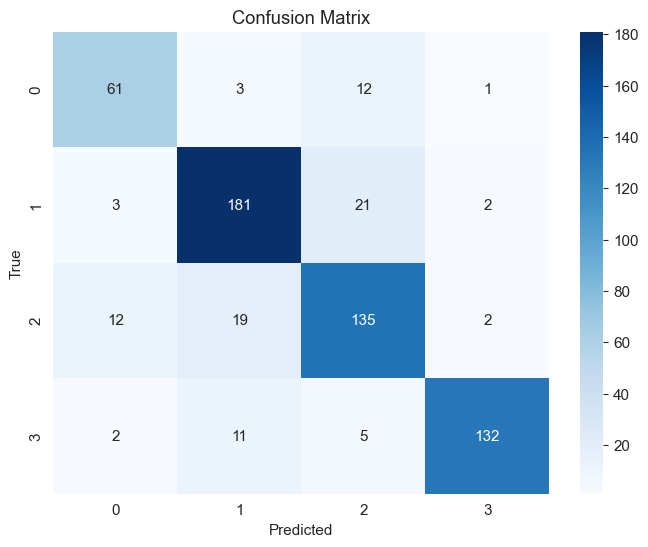

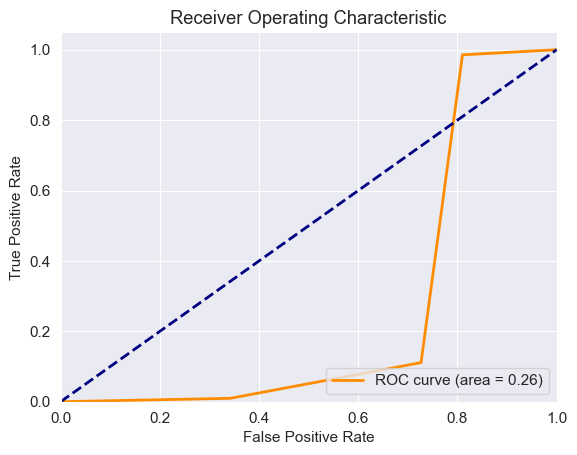

In [19]:
# Gọi các hàm với đường dẫn chính xác
yolo_model_path = '../data/content/yolov5/runs/train/yolov5x_results/weights/best.pt'
cnn_model_path = '../Pycode/final_model.h5'
image_directory = '../data/Lung_CT_Scan/valid/images'
labels_directory = '../data/Lung_CT_Scan/valid/labels'

# Tải mô hình YOLOv5
yolo_model = load_yolov5_model(yolo_model_path)

# Tải mô hình CNN
cnn_model = load_cnn_model(cnn_model_path)

# Đánh giá tổng thể mô hình YOLOv5 + CNN
evaluate_combined_model(image_directory, labels_directory, yolo_model, cnn_model)